In [1]:
import pandas as pd
import joblib 
import numpy as np 


from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report


In [2]:
baseline_df = joblib.load("ipo_stats.pkl")

**Define Dependent Variable**

In [3]:
baseline_df['delta_close'] = baseline_df['offer_price'] - baseline_df['1st_day_close']

In [4]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
baseline_df['delta_close_norm'] = normalize_data(baseline_df['delta_close'])

In [5]:
baseline_df['ipo_success'] = baseline_df['delta_close_norm']>=.9
baseline_df['ipo_success'].value_counts()

True     6284
False    2099
Name: ipo_success, dtype: int64

**Feature Engineering**

In [6]:
def delta_years(df,col1,col2):
    df[col1] = df[col1].astype(str)
    df[col2] = df[col2].str.replace('.','0').astype(int)
    df[col1] = df[col1].map(lambda x: int(x[:4]))
    delta = df[col1]-df[col2]
    return delta



In [7]:
baseline_df['years_to_ipo'] = delta_years(baseline_df,'trade_date','founding')    


<ipython-input-6-9fc5f488b097>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col2] = df[col2].str.replace('.','0').astype(int)


In [8]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8383 entries, 0 to 9630
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trade_date         8383 non-null   int64  
 1   company_name       8383 non-null   object 
 2   ticker             8383 non-null   object 
 3   offer_price        8383 non-null   float64
 4   opening_price      8383 non-null   float64
 5   1st_day_close      8383 non-null   float64
 6   star_ratings       8383 non-null   object 
 7   managers           8383 non-null   object 
 8   founding           8383 non-null   int64  
 9   vc_dummy           8383 non-null   object 
 10  rollup             8383 non-null   object 
 11  dual               8383 non-null   object 
 12  post-issue_shares  8383 non-null   float64
 13  internet           8383 non-null   object 
 14  delta_close        8383 non-null   float64
 15  delta_close_norm   8383 non-null   float64
 16  ipo_success        8383 

In [9]:
baseline_df.drop(baseline_df.columns[np.r_[0:6,8,12,14,15]], axis=1, inplace=True)

In [10]:
baseline_df

,star_ratings,managers,vc_dummy,rollup,dual,internet,ipo_success,years_to_ipo
0,2,Jefferies,0,.,1,0,True,6
1,1,Credit Suisse,1,.,1,0,True,10
2,1,Citigroup,0,.,1,0,True,5
3,1,Wells Fargo Securities,2,0,0,0,True,16
6,1,WestPark Capital,0,0,1,0,True,10
...,...,...,...,...,...,...,...,...
9626,1,Wells Fargo Securities,1,0,0,0,True,37
9627,1,Wells Fargo Securities,0,0,1,0,True,26
9628,2,Wells Fargo Securities,2,0,0,0,True,19
9629,3,Baird,0,0,0,0,True,35


# Baseline Model

In [11]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8383 entries, 0 to 9630
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   star_ratings  8383 non-null   object
 1   managers      8383 non-null   object
 2   vc_dummy      8383 non-null   object
 3   rollup        8383 non-null   object
 4   dual          8383 non-null   object
 5   internet      8383 non-null   object
 6   ipo_success   8383 non-null   bool  
 7   years_to_ipo  8383 non-null   int64 
dtypes: bool(1), int64(1), object(6)
memory usage: 532.1+ KB


In [12]:
x_feats = ['star_ratings', 
           'managers', 
           'years_to_ipo', 
           'vc_dummy', 
           'rollup', 
           'dual', 
           'internet'
           ]
X = pd.get_dummies(baseline_df[x_feats], drop_first=True)
y = baseline_df['ipo_success'].astype(int)
X.head()

,years_to_ipo,star_ratings_2,star_ratings_3,star_ratings_4,star_ratings_5,star_ratings_N/C,star_ratings_NC,managers_,managers_ RBC Capital Markets,managers_ A.G.P.,...,vc_dummy_2,rollup_0,rollup_1,dual_0,dual_1,dual_2,dual_9,internet_0,internet_1,internet_9
0,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,16,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
6,10,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


**Train Test Split**

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Baseline Logistic Model**

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [15]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

**Baseline Model Results**

In [16]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    5295
1     992
Name: ipo_success, dtype: int64
0    0.842214
1    0.157786
Name: ipo_success, dtype: float64


In [17]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    1673
1     423
Name: ipo_success, dtype: int64
0    0.798187
1    0.201813
Name: ipo_success, dtype: float64


In [18]:
acc = accuracy_score(y_train,y_hat_train) 
acc = accuracy_score(y_test,y_hat_test) 

print('Train Accuracy Score: {}'.format(acc)) 
print('Test Accuracy Score: {}'.format(acc)) 

Train Accuracy Score: 0.7981870229007634
Test Accuracy Score: 0.7981870229007634


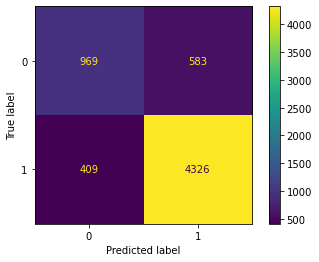

In [19]:
logreg_matrix = plot_confusion_matrix(model_log,X_train, y_train)


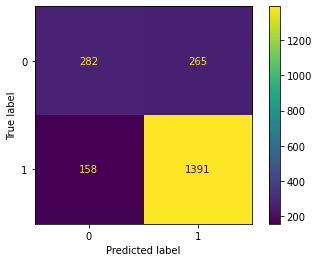

In [20]:
logreg_matrix = plot_confusion_matrix(model_log,X_test, y_test)
